# Рекомендательная система для "Мегалайн"

## Общее описание проекта

* Целью проекта является готовая система, способная проанализировать поведение клиннтов и предложить им новый тариф: "Смарт" или "Ультра".
* Исходно даны данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.
* Требуемое значени accuracy >= 0.75.

### План:

1) Получить данные и изучить общую информацию о них.
2) Разделить исходные данные на обучающую, валидационную и тестовую выборки.
3) Исследовать качество разных моделей, меняя гиперпараметры.
4) Проверить качество модели на тестовой выборке.
5) Проверить модели на вменяемость.

### Подключение библиотек

In [18]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Общие сведения о данных

### Получение данных 

In [3]:
try: 
    data = pd.read_csv('../../datasets/users_behavior.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

### Общая информация о данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [6]:
# Проверяем количество пропусков
data.isnull().sum()*100/len(data)

calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

In [38]:
# Проверка на явные дубликаты
data.duplicated().sum()

0

Следует изменить тип в колонках calls и messages на int для экономии памяти.

In [39]:
data['calls'] = data['calls'].astype('int')
data['messages'] = data['messages'].astype('int')

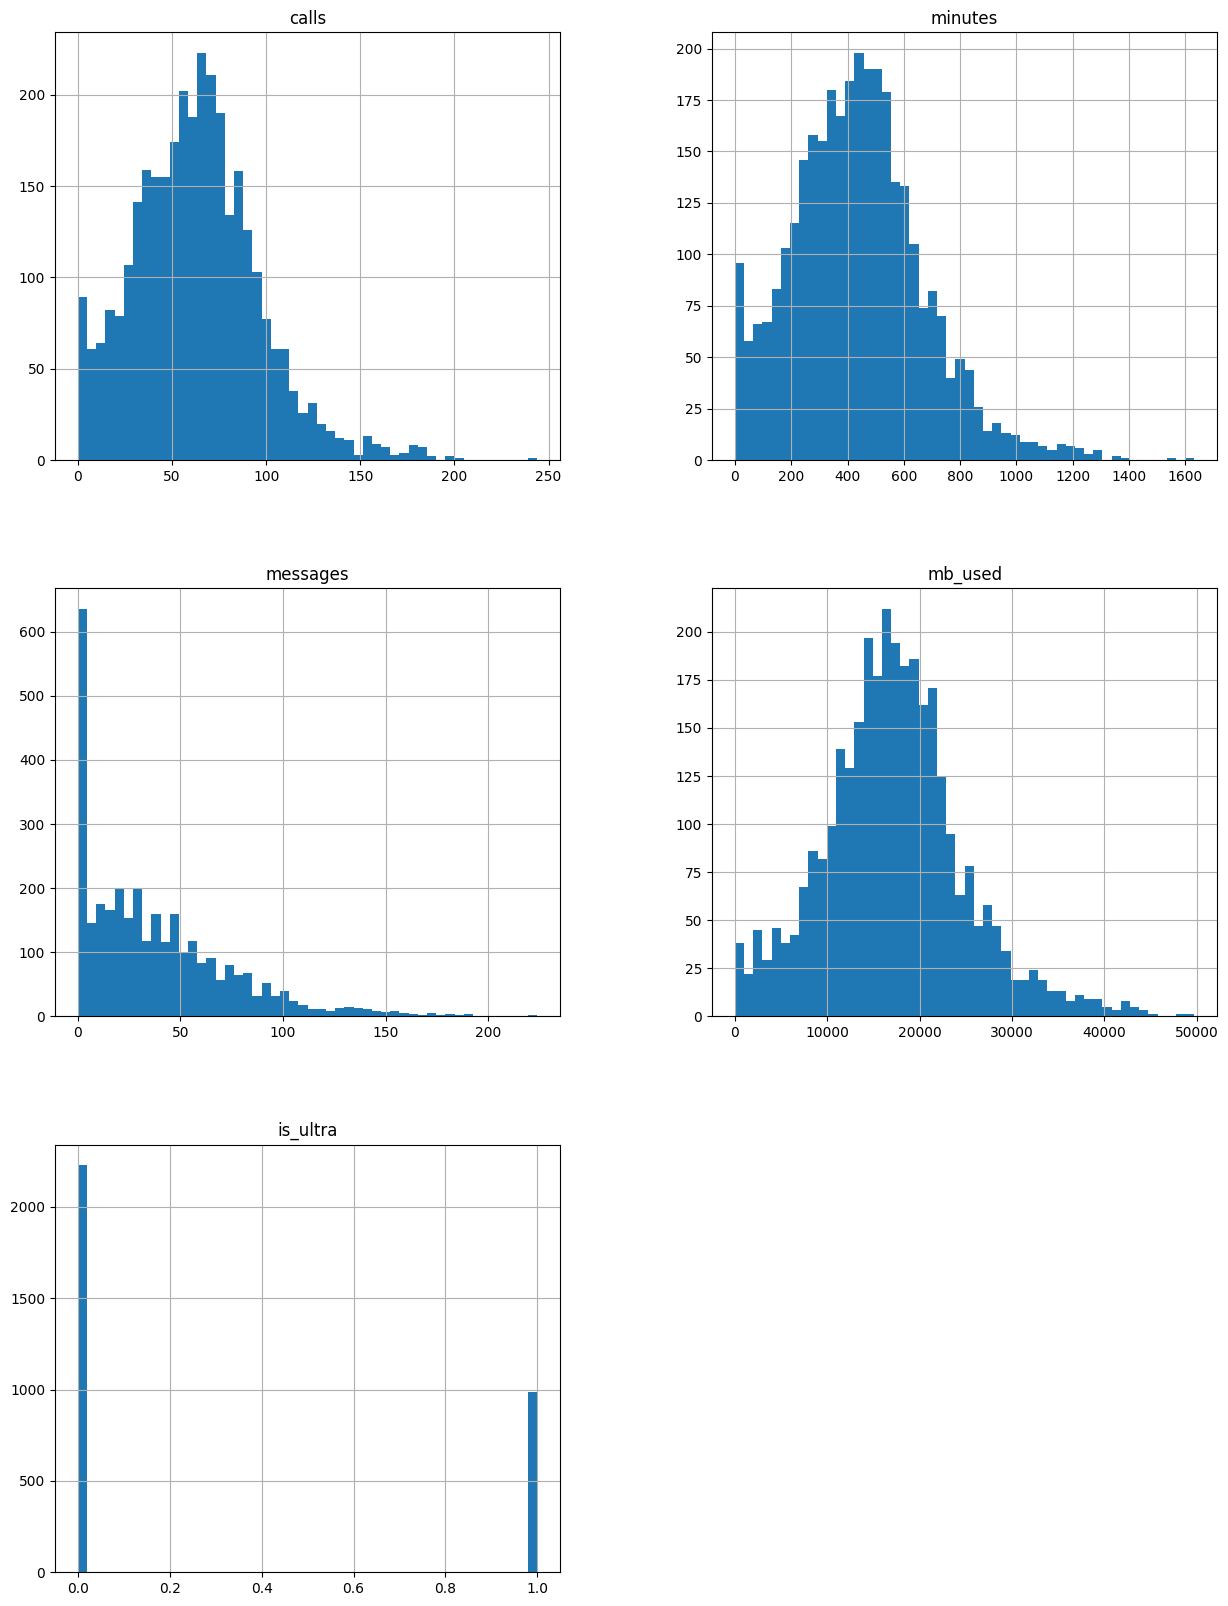

In [36]:
data.hist(figsize=(15, 20), bins=50);

### Вывод по разделу

В данных не обнаружено серьезных проблем, были только изменены типы в колонках calls и messages.
Признаки в каждой колонке напоминают распределение Пуассона. На каждом графике наблюдаются выбросы в нуле, но это тоже ценные данные, поэтому трогать их не будем. 

## Разделение данных на обучающую, валидационную и тестовую выборку

### Разделение дантасета на признаки и целевой признак

In [8]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

### Разделение данных на выборки

In [13]:
# Сначала разделим на выборки для обучения и валидационную и тестовую(в одной выборке) 
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.4, random_state=12345)

In [14]:
# Разделим получившуюся выборку для проверки на валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=.5, random_state=12345)

In [37]:
display(features_train.count())
display(features_valid.count())
features_test.count()

calls       1928
minutes     1928
messages    1928
mb_used     1928
dtype: int64

calls       643
minutes     643
messages    643
mb_used     643
dtype: int64

calls       643
minutes     643
messages    643
mb_used     643
dtype: int64

Данные разделены правильно в соотношении 3:1:1 на тренировочную, валидационную и тестовую выборки соответственно. 

### Вывод по разделу

Данные были разделены на тренировочные, валидационные и тестовые выборки.

## Исследование моделей

### Исследуем эффективность логистической регрессии

In [30]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)

result = model.score(features_valid, target_valid)
display("accuracy модели на валидационной выборке:", result)

'accuracy модели на валидационной выборке:'

0.7107309486780715

### Исследуем эффективность дерева решений

В цикле подберем гиперпараметры с которыми модель получит наивысшее значение accuracy

In [31]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

display("accuracy наилучшей модели на валидационной выборке:", best_result, "Глубина дерева:", best_depth)

'accuracy наилучшей модели на валидационной выборке:'

0.7853810264385692

'Глубина дерева:'

3

### Исследуем эффективность случайного леса

В цикле подберем гиперпараметры с которыми модель получит наивысшее значение accuracy

In [33]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

display("accuracy наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

'accuracy наилучшей модели на валидационной выборке:'

0.8087091757387247

'Количество деревьев:'

40

'Максимальная глубина:'

10

### Вывод по разделу

Максимальное значение accuracy получила модель случайного леса, но и решающее дерево также получило удовлетворительный результат, при меньших затратах вычислительных ресурсов. 
В данном проекте не так важна скорость работы модели, поэтому в качестве лучшей модели выберем случайный лес.

## Тестирование модели на тестовой выборке

Проверяем значение accuracy случайного леса на тестовой выборке

In [34]:
accuracy_test = best_model.score(features_test, target_test)
accuracy_test

0.7962674961119751

### Вывод по разделу 

Обученная в предыдущем разделе модель случайного леса (с гиперпапаметрами: количество деревьев - 40, максимальная глубина - 10) на тестовой выборке имеет долю правильных ответов примерно 79,6%, что удовлетворяет условию.

## Проверка модели на вменяемость